## Libs

In [37]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier 

In [38]:
def print_metrics(true, pred):
    # calculate metrics & create visualizations
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"accuracy: {accuracy_score(true, pred):.3f}")
    print(f"precision: {precision_score(true, pred):.3f}")
    print(f"recall: {recall_score(true, pred):.3f}")
    print(f"f1 (avg=binary): {f1_score(true, pred, average='binary'):.3f}")
    print(f"f1 (avg=macro): {f1_score(true, pred, average='macro'):.3f}")

## Read data

In [39]:
# merged both datasets to apply fixes for both, splitting again
df = pd.read_csv("interdata/df_fixed_01.csv")

## Feature Engineering

In [42]:
# to date 
df['repair_date'] = pd.to_datetime(df['repair_date'])
df['breakdown_date'] = pd.to_datetime(df['breakdown_date'])

In [43]:
# normalize some time features by "age"
df['reg_date'] = pd.to_datetime(df['Reg_year'].astype(str) + '-01-01')
df['car_age_yr'] = (df['breakdown_date'] - df['reg_date']) /  pd.Timedelta(days=365.25)
df['mileage_yr'] = df['Runned_Miles'] / df['car_age_yr']

# Replace missing values in 'repair_date' with values from 'breakdown_date'
df['repair_date'] = df['repair_date'].fillna(df['breakdown_date'])

df['repair_weekday'] = df['repair_date'].dt.day_name()

In [44]:
# deal with datetime columns
df['repair_date'] = (df['repair_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
df['breakdown_date'] = (df['breakdown_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)

In [45]:
# select columns
df = df[['ID', 'Maker', 
       'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size',
       'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'issue',
       'issue_id', 'breakdown_date', 'repair_complexity',
       'repair_cost', 'repair_hours', 'repair_date', 'value', 'Label', 
       'car_age_yr', 'mileage_yr', 'repair_weekday']]
df.head()

,ID,Maker,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,issue_id,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,value,Label,car_age_yr,mileage_yr,repair_weekday
0,16130,Ford,Blue,2017,Hatchback,1636,1.2,Manual,Petrol,7490,5,5,Tyre Alignment,0,17636,1,10.749000,0.500000,17636,7116.045727,0.0,1.284052,1274.091684,Sunday
1,16131,Ford,Blue,2016,SUV,9820,2.0,Manual,Diesel,23995,5,5,Radiator Leaking,0,17671,1,519.900000,2.000000,17671,22790.624277,0.0,2.381930,4122.706897,Sunday
2,16132,Honda,Grey,2012,SUV,38500,2.2,Automatic,Diesel,11750,5,5,Sensor Malfunction,0,17769,1,3059.099027,2172.572165,17772,11158.396445,1.0,6.650240,5789.265130,Wednesday
3,16133,Ford,Silver,2012,SUV,43445,2.0,Manual,Diesel,9999,5,5,Gear Box Issue,0,17657,1,571.012064,437.382279,17676,9492.344018,1.0,6.343600,6848.634549,Friday
4,16134,Honda,Grey,2018,SUV,7491,1.6,Manual,Diesel,21999,5,5,Alternator Failing,0,17687,1,479.980000,2.000000,17687,20903.668754,0.0,0.424367,17652.179032,Tuesday


In [46]:
df_val    = df[df['Label'].isna()]
df_train  = df[df['Label'].notna()]

print("Dimensions of the df_test:", df_val.shape)
print("Dimensions of the df_train:", df_train.shape)

Dimensions of the df_test: (16129, 24)
Dimensions of the df_train: (37637, 24)
Dimensions of the df_test: (16129, 24)
Dimensions of the df_train: (37637, 24)


In [47]:
X = df_train.drop(columns=["Label"])
y = df_train["Label"]
# X_test = df_val.drop(columns=["Label"])
# y_test = df_val["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Pipelines

### baseline: logistic regression

In [12]:
# Assign the numerical and categorical (nominal) columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

#numerical_features = ['Age', 'Flight distance'] # for tree-based methods
numerical_features = [col for col in X.columns.tolist() if col not in categorical_features]  # for linear methods

print(categorical_features)
print(numerical_features)

['Maker', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type', 'issue', 'repair_weekday']
['ID', 'Reg_year', 'Runned_Miles', 'Engin_size', 'Price', 'Seat_num', 'Door_num', 'issue_id', 'breakdown_date', 'repair_complexity', 'repair_cost', 'repair_hours', 'repair_date', 'value', 'car_age_yr', 'mileage_yr']
['Maker', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type', 'issue', 'repair_weekday']
['ID', 'Reg_year', 'Runned_Miles', 'Engin_size', 'Price', 'Seat_num', 'Door_num', 'issue_id', 'breakdown_date', 'repair_complexity', 'repair_cost', 'repair_hours', 'repair_date', 'value', 'car_age_yr', 'mileage_yr']


In [13]:
# Define the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), categorical_features)
    ])

In [14]:
# Count the number of missing (NaN) values in each column
missing_counts = df_train.isna().sum()
missing_counts

ID                   0
Maker                0
Color                0
Reg_year             0
Bodytype             0
Runned_Miles         0
Engin_size           0
Gearbox              0
Fuel_type            0
Price                0
Seat_num             0
Door_num             0
issue                0
issue_id             0
breakdown_date       0
repair_complexity    0
repair_cost          0
repair_hours         0
repair_date          0
value                0
Label                0
car_age_yr           0
mileage_yr           0
repair_weekday       0
dtype: int64

In [49]:
# Now, the pipeline applies the appropriate transformations
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
    ('classifier', LogisticRegression())]
)

# Fit your pipeline on the training data
pipeline.fit(X_train, y_train)

# Apply your pipeline to the test set
y_pred_lm = pipeline.predict(X_test)

/home/avila/.cache/pypoetry/virtualenvs/preproject-P6GzOAxP-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
print_metrics(y_test, y_pred_lm)
# ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lm)).plot()

accuracy: 0.884
precision: 0.609
recall: 0.430
f1 (avg=binary): 0.504
f1 (avg=macro): 0.719
accuracy: 0.884
precision: 0.609
recall: 0.430
f1 (avg=binary): 0.504
f1 (avg=macro): 0.719


### XGBClassifier

In [51]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=42))
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [52]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


search_space = {
    'clf__max_depth': Integer(14,16),
    'clf__learning_rate': Real(0.05, 0.3, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 1.0),
    'clf__reg_lambda': Real(0.0, 1.0),
    'clf__gamma': Real(2.7, 3.1)
}

opt = BayesSearchCV(
    pipe, search_space, cv=6, n_iter=100, scoring="f1_macro", random_state=4422
) 

In [53]:
opt.fit(X_train, y_train)
print(f"best score: {opt.best_score_}")

best score: 0.8560248386330783
best score: 0.8560248386330783


Best Threshold: 0.31313131313131315
Best Threshold: 0.31313131313131315


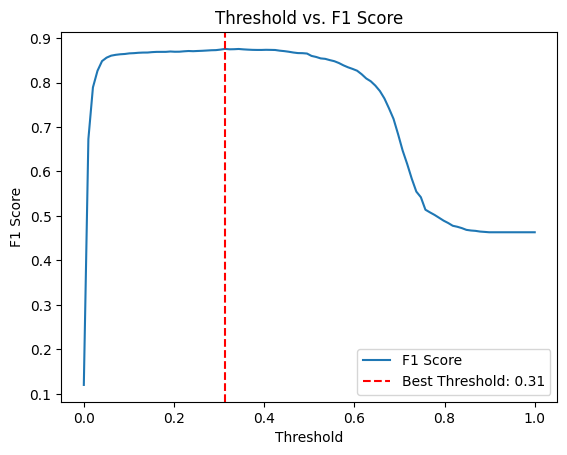

In [61]:
# Assuming you have already performed the search
best_model = opt.best_estimator_

# Predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]  # X_test is your test/validation data

# True labels
y_true = y_test  # y_test is your test/validation labels

# Range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Evaluate F1-score for each threshold
from sklearn.metrics import f1_score
f1_scores = [f1_score(y_true, y_probs >= t, average='macro') for t in thresholds]

# Best threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

import matplotlib.pyplot as plt

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs. F1 Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.legend()
plt.show()

In [62]:
y_pred = opt.best_estimator_.predict(X_test)
print_metrics(y_test, y_pred)

accuracy: 0.928
precision: 0.691
recall: 0.859
f1 (avg=binary): 0.766
f1 (avg=macro): 0.862
accuracy: 0.928
precision: 0.691
recall: 0.859
f1 (avg=binary): 0.766
f1 (avg=macro): 0.862


In [63]:
## export validation set 

# export predictionsdf_val
try: df_val = df_val.drop(columns='Label')
except: pass 

y_validation_proba = opt.best_estimator_.predict_proba(df_val)[:,1]
df_val['Label'] =  (y_validation_proba >= best_threshold).astype(int)
df_val.head()

# Get the current date
from datetime import datetime
date_str = datetime.now().strftime('%Y%m%d')
filename = f"./outdata/predicted_{date_str}.csv"

cols_to_export = ['ID', 'Label']
df_export = df_val[cols_to_export]
df_export.to_csv(filename, index=False)

In [56]:
# export predictionsdf_val
try: df_val = df_val.drop(columns='Label')
except: pass 
y_validation = opt.best_estimator_.predict(df_val)

In [57]:

df_val['Label'] = y_validation
df_val.head()

# Get the current date
date_str = datetime.now().strftime('%Y%m%d')
filename = f"./outdata/predicted_{date_str}.csv"

cols_to_export = ['ID', 'Label']
df_export = df_val[cols_to_export]
df_export.to_csv(filename, index=False)

Feature imporatnce


In [58]:
xg = opt.best_estimator_._final_estimator

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

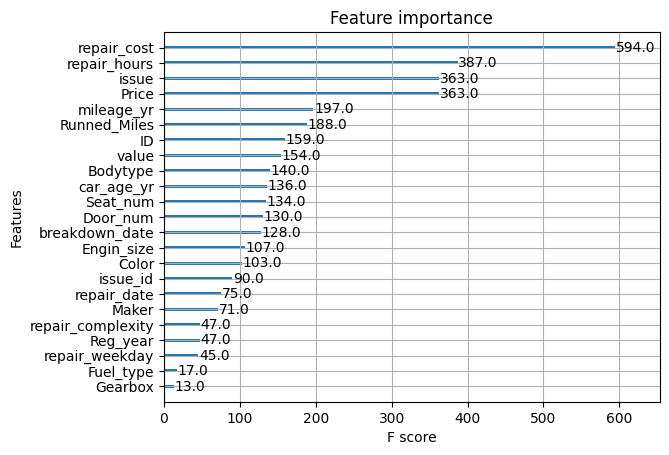

In [59]:
xgb.plot_importance(xg)

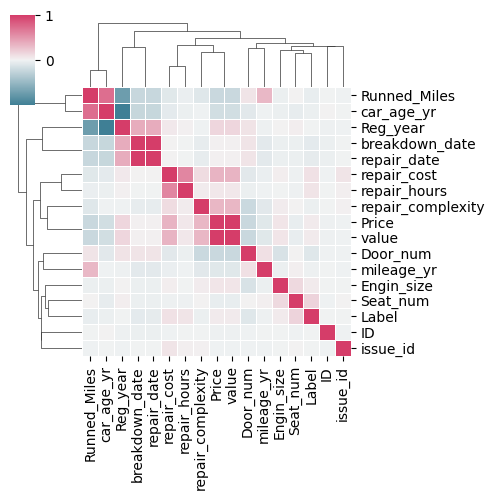

In [60]:
import seaborn as sns
corr = df_train[numerical_features + ["Label"]].corr()
clustergrid = sns.clustermap(corr, cmap=sns.diverging_palette(222, 0, as_cmap=True), figsize=(5, 5), linewidths=0.5)